In [12]:
import torch
import torch.nn as nn
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric.nn import GCNConv
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import porespy as ps

ps.visualization.set_mpl_style()

# Preprocess all images in a folder
input_folder = "C:\\Users\\ai_to\\Downloads\\RPMR\\RPMR\\Samples"
output_folder = "C:\\Users\\ai_to\\Downloads\\RPMR\\RPMR\\Preprocessed"


In [3]:
# Define the model architecture
class TortuosityPrediction(nn.Module):
    def __init__(self):
        super(TortuosityPrediction, self).__init__()

        self.recurrent = GConvGRU(
            in_channels=1,
            out_channels=64,
            kernel_size=3,
            timesteps=10,
            num_layers=2,
            convolution=GCNConv,
        )

        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(0)  # Add a batch dimension
        x = x.transpose(1, 2)  # Reshape input for GConvGRU
        h = self.recurrent(x)
        h = h.transpose(1, 2)  # Reshape output for linear layer
        out = self.linear(h)
        out = out.squeeze(0)  # Remove the batch dimension
        return out


In [20]:
def load_image (image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # Crop the image to show only the central region
    height, width, _ = image.shape
    crop_width = 125
    cropped_image = image[:, crop_width:(width - crop_width)]
    return cropped_image
    
def preprocess_image(image_path, output_folder, image_name):
    # Read the image
    image = load_image(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply adaptive thresholding to segment the image
    _, segmented = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over the contours and draw them on the original image
    for contour in contours:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # If the area is smaller than a certain threshold, consider it as a pore
        if area < 100:
            cv2.drawContours(segmented, [contour], -1, (0, 0, 0), -1)
        else:
            cv2.drawContours(segmented, [contour], -1, (255, 255, 255), -1)
    segmented = cv2.cvtColor(segmented, cv2.COLOR_GRAY2BGR)
    segmented = cv2.resize(segmented, (64,64))
    image = cv2.resize(image, (64,64))
    # Save the preprocessed image with the original .tif extension
    processed_image_path = os.path.join(output_folder, image_name)
    return segmented, image

cropped_images = []
preprocessed_images = []
for image_file in os.listdir(input_folder):
    if image_file.endswith(".tif"):
        image_path = os.path.join(input_folder, image_file)
        image, cropped_image = preprocess_image(image_path, output_folder, image_file)
        preprocessed_images.append(image)
        cropped_images.append(cropped_image)

In [23]:
preprocessed_images[0].shape


(64, 64, 3)

In [24]:
np.save('preprocessed_images.npy', preprocessed_images)
np.save('images.npy', cropped_images)

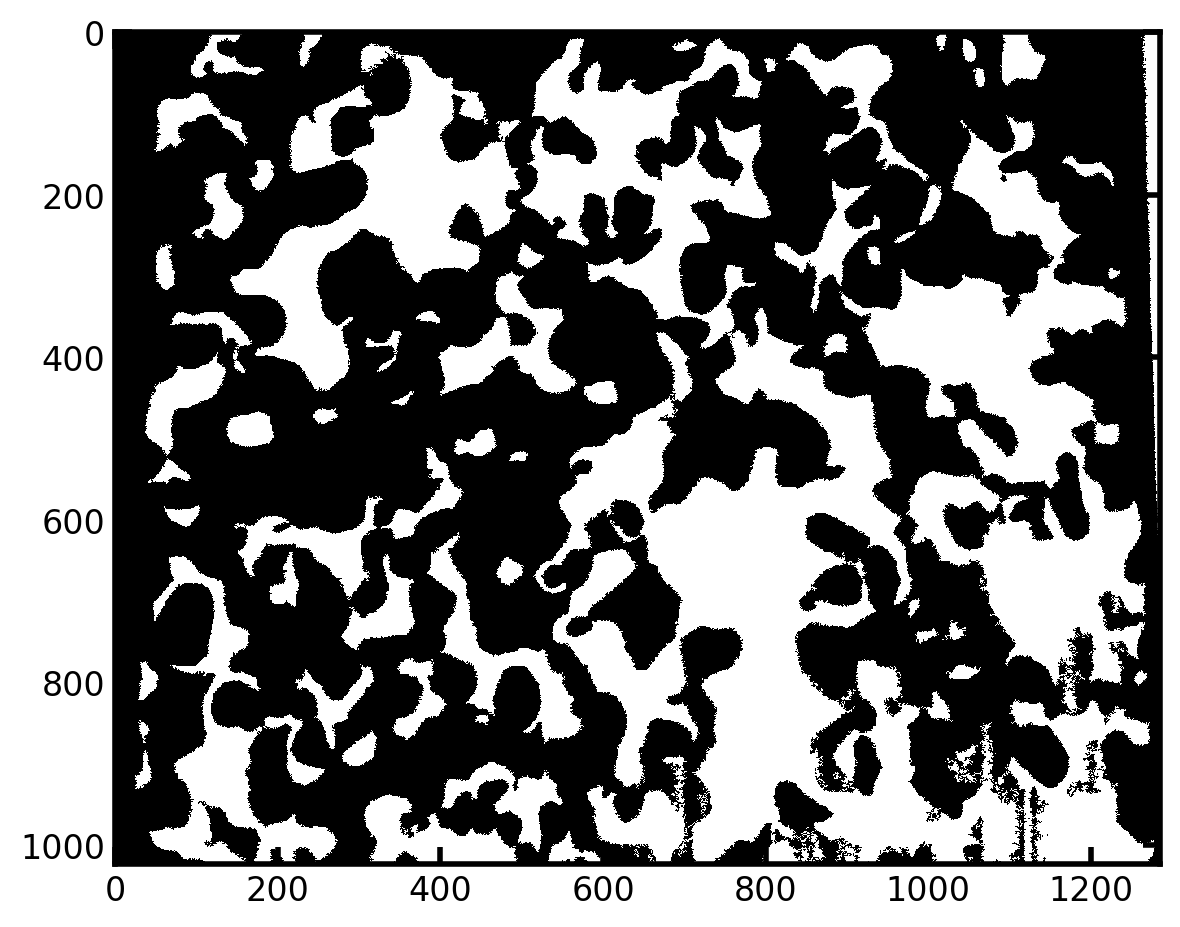

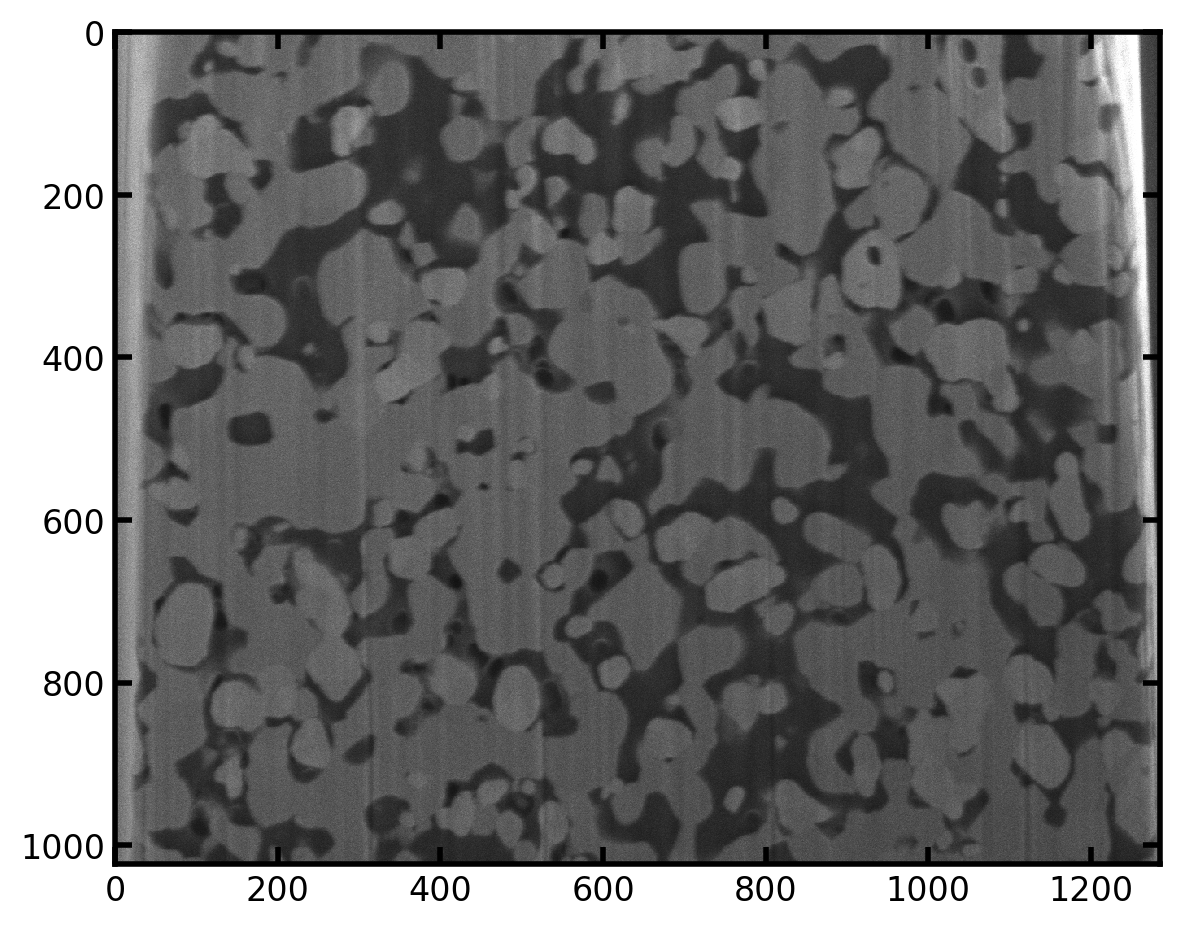

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [10]:
plt.imshow(preprocessed_images[0])
plt.show()
plt.imshow(cropped_images[0], cmap="gray")
plt.show()
preprocessed_images[0]

In [84]:
#tortuosity = ps.simulations.tortuosity_fd(im=cropped_images[0], axis=0)
#print(tortuosity)
im = preprocessed_images[0]
#lt = ps.simulations.tortuosity_fd(im, axis=0)
#print(lt)
e = ps.metrics.porosity(im)
print(e)

0.0
